In [1]:
%load_ext Cython

In [2]:
import matplotlib.pyplot as pyplot
import optuna as op
%matplotlib inline
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Utils.createURM import createURM
from Utils.createICM import createICM
from Utils.combineURMICM import combine

In [3]:
URM = createURM()
ICM = createICM()

C:\Users\Mike\PycharmProjects\recsys-challenge-2022-Pancini-Vitali\Utils\createURM.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('../Input/interactions_and_impressions.csv')
C:\Users\Mike\PycharmProjects\recsys-challenge-2022-Pancini-Vitali\Utils\createICM.py:14: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  URM = pd.read_csv('../Input/interactions_and_impressions.csv')


In [4]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

In [5]:
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 763 ( 1.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 290 ( 0.7%) Users that have less than 1 test interactions


In [7]:
URMICMCombined = combine(ICM, URM_train)

## Neighbors

In [9]:
x_tick = [10, 25, 40, 50, 100]
MAP_per_k = []

for topK in x_tick:

    recommender = ItemKNNCFRecommender(URMICMCombined.T)
    recommender.fit(shrink=0.0, topK=topK)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_k.append(result_df.loc[10]["MAP"])

Similarity column 24507 (100.0%), 2565.97 column/sec. Elapsed time 9.55 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 19.09 sec. Users per second: 2141
Similarity column 24507 (100.0%), 2544.49 column/sec. Elapsed time 9.63 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 19.68 sec. Users per second: 2077
Similarity column 24507 (100.0%), 2771.53 column/sec. Elapsed time 8.84 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 20.04 sec. Users per second: 2039
Similarity column 24507 (100.0%), 2763.65 column/sec. Elapsed time 8.87 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 20.39 sec. Users per second: 2005
Similarity column 24507 (100.0%), 2761.77 column/sec. Elapsed time 8.87 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 21.38 sec. Users per second: 1912


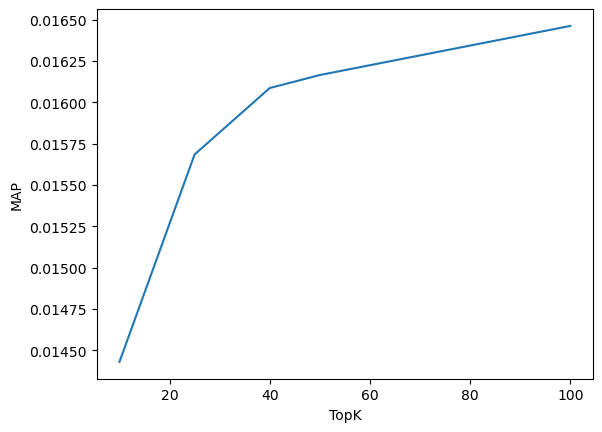

In [10]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

## Shrink

In [11]:
x_tick = [0, 10, 50, 100, 200]
MAP_per_shrinkage = []

for shrink in x_tick:

    recommender = ItemKNNCFRecommender(URMICMCombined.T)
    recommender.fit(shrink=shrink, topK=45)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

Similarity column 24507 (100.0%), 2658.43 column/sec. Elapsed time 9.22 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 21.09 sec. Users per second: 1938
Similarity column 24507 (100.0%), 2592.26 column/sec. Elapsed time 9.45 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 20.95 sec. Users per second: 1951
Similarity column 24507 (100.0%), 2665.39 column/sec. Elapsed time 9.19 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 20.89 sec. Users per second: 1956
Similarity column 24507 (100.0%), 2655.82 column/sec. Elapsed time 9.23 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 21.26 sec. Users per second: 1922
Similarity column 24507 (100.0%), 2649.08 column/sec. Elapsed time 9.25 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 21.71 sec. Users per second: 1882


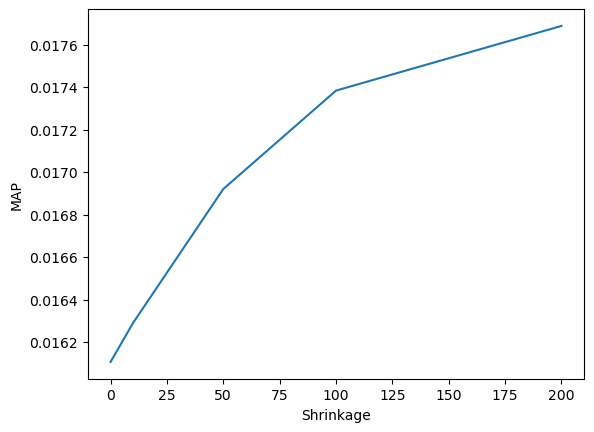

In [12]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

## OPTUNA optimization

In [13]:
# objective = represents the function that we need to minimize
# trial = optuna parameter that tries random values in a certain interval
recommender = ItemKNNCFRecommender(URMICMCombined.T)
def objective(trial):
    topK = trial.suggest_int("topK", 95, 100)
    shrink = trial.suggest_float("shrink", 195, 200)
    recommender.fit(topK=topK, shrink=shrink)
    result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

    return result_dict.loc[10]["MAP"]

In [14]:
study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2022-11-06 14:13:52,838] A new study created in memory with name: no-name-30f910bc-7017-4c13-998a-383d5b293122


Similarity column 24507 (100.0%), 2462.02 column/sec. Elapsed time 9.95 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 27.15 sec. Users per second: 1505


[I 2022-11-06 14:14:30,189] Trial 0 finished with value: 0.01766430878620692 and parameters: {'topK': 95, 'shrink': 197.7896686683152}. Best is trial 0 with value: 0.01766430878620692.


Similarity column 24507 (100.0%), 2330.33 column/sec. Elapsed time 10.52 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 23.76 sec. Users per second: 1720


[I 2022-11-06 14:15:04,600] Trial 1 finished with value: 0.01766980875940621 and parameters: {'topK': 98, 'shrink': 198.71105177536322}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2557.97 column/sec. Elapsed time 9.58 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 22.85 sec. Users per second: 1789


[I 2022-11-06 14:15:37,175] Trial 2 finished with value: 0.017652322262694926 and parameters: {'topK': 100, 'shrink': 198.35097327609952}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2635.60 column/sec. Elapsed time 9.30 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 22.98 sec. Users per second: 1778


[I 2022-11-06 14:16:09,599] Trial 3 finished with value: 0.017663372703197736 and parameters: {'topK': 99, 'shrink': 196.26271121124992}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2549.59 column/sec. Elapsed time 9.61 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 23.67 sec. Users per second: 1726


[I 2022-11-06 14:16:43,040] Trial 4 finished with value: 0.017664898207769775 and parameters: {'topK': 99, 'shrink': 197.2765782266375}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2627.85 column/sec. Elapsed time 9.33 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 23.49 sec. Users per second: 1740


[I 2022-11-06 14:17:15,986] Trial 5 finished with value: 0.017661707368798595 and parameters: {'topK': 99, 'shrink': 195.10201946766082}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2649.37 column/sec. Elapsed time 9.25 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 22.94 sec. Users per second: 1781


[I 2022-11-06 14:17:48,286] Trial 6 finished with value: 0.017656679321265766 and parameters: {'topK': 97, 'shrink': 195.3035024494754}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2643.57 column/sec. Elapsed time 9.27 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 22.49 sec. Users per second: 1817


[I 2022-11-06 14:18:20,195] Trial 7 finished with value: 0.01766441657169866 and parameters: {'topK': 98, 'shrink': 195.8274947347339}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2632.19 column/sec. Elapsed time 9.31 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 22.91 sec. Users per second: 1784


[I 2022-11-06 14:18:52,555] Trial 8 finished with value: 0.017652322262694926 and parameters: {'topK': 100, 'shrink': 198.61333388556133}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2524.57 column/sec. Elapsed time 9.71 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 24.00 sec. Users per second: 1703


[I 2022-11-06 14:19:26,398] Trial 9 finished with value: 0.017666651906851336 and parameters: {'topK': 96, 'shrink': 195.49504498937014}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2445.82 column/sec. Elapsed time 10.02 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 24.09 sec. Users per second: 1696


[I 2022-11-06 14:20:00,669] Trial 10 finished with value: 0.01766294253227131 and parameters: {'topK': 97, 'shrink': 199.92244045152844}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2497.12 column/sec. Elapsed time 9.81 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 23.59 sec. Users per second: 1733


[I 2022-11-06 14:20:34,202] Trial 11 finished with value: 0.01766062077451714 and parameters: {'topK': 95, 'shrink': 199.28616432412093}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2340.37 column/sec. Elapsed time 10.47 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 23.65 sec. Users per second: 1728


[I 2022-11-06 14:21:08,461] Trial 12 finished with value: 0.017667921056740362 and parameters: {'topK': 96, 'shrink': 196.6588358074963}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2572.38 column/sec. Elapsed time 9.53 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 23.09 sec. Users per second: 1770


[I 2022-11-06 14:21:41,235] Trial 13 finished with value: 0.017667921056740362 and parameters: {'topK': 96, 'shrink': 196.6657530258407}. Best is trial 1 with value: 0.01766980875940621.


Similarity column 24507 (100.0%), 2567.10 column/sec. Elapsed time 9.55 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 23.43 sec. Users per second: 1744


[I 2022-11-06 14:22:14,334] Trial 14 finished with value: 0.017670770089467523 and parameters: {'topK': 98, 'shrink': 197.2032638135321}. Best is trial 14 with value: 0.017670770089467523.


Similarity column 24507 (100.0%), 2553.99 column/sec. Elapsed time 9.60 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 23.53 sec. Users per second: 1737


[I 2022-11-06 14:22:47,599] Trial 15 finished with value: 0.017670770089467523 and parameters: {'topK': 98, 'shrink': 197.76516382165187}. Best is trial 14 with value: 0.017670770089467523.


Similarity column 24507 (100.0%), 2513.79 column/sec. Elapsed time 9.75 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 23.77 sec. Users per second: 1719


[I 2022-11-06 14:23:21,251] Trial 16 finished with value: 0.017670770089467523 and parameters: {'topK': 98, 'shrink': 197.54319662978025}. Best is trial 14 with value: 0.017670770089467523.


Similarity column 24507 (100.0%), 2538.75 column/sec. Elapsed time 9.65 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 23.55 sec. Users per second: 1735


[I 2022-11-06 14:23:54,590] Trial 17 finished with value: 0.017664003879500623 and parameters: {'topK': 97, 'shrink': 197.1894695772097}. Best is trial 14 with value: 0.017670770089467523.


Similarity column 24507 (100.0%), 2549.50 column/sec. Elapsed time 9.61 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 23.22 sec. Users per second: 1760


[I 2022-11-06 14:24:27,548] Trial 18 finished with value: 0.017666995655176286 and parameters: {'topK': 99, 'shrink': 198.11639141650673}. Best is trial 14 with value: 0.017670770089467523.


Similarity column 24507 (100.0%), 2581.00 column/sec. Elapsed time 9.50 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 24.00 sec. Users per second: 1703


[I 2022-11-06 14:25:01,166] Trial 19 finished with value: 0.017670770089467523 and parameters: {'topK': 98, 'shrink': 197.8123335749304}. Best is trial 14 with value: 0.017670770089467523.


Similarity column 24507 (100.0%), 2557.79 column/sec. Elapsed time 9.58 sec
EvaluatorHoldout: Processed 40866 (100.0%) in 23.56 sec. Users per second: 1734


[I 2022-11-06 14:25:34,469] Trial 20 finished with value: 0.01765971188064101 and parameters: {'topK': 97, 'shrink': 196.7161676857243}. Best is trial 14 with value: 0.017670770089467523.


Similarity column 24507 (100.0%), 2541.71 column/sec. Elapsed time 9.64 sec


KeyboardInterrupt: 

In [ ]:
topK = study.best_params['topK']
shrink = study.best_params['shrink']

In [ ]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=shrink, topK=topK)
result_df, _ = evaluator_test.evaluateRecommender(recommender)
result_df